# Error subspace SDP

In this ipynb file, we implement SDP for optimal recovery. We consider entanglement fidelity
\begin{align}
F_{\mathcal{N}_\gamma, \mathcal{R}}=\left\langle\Psi\left|\left(\mathcal{R} \circ \mathcal{N}_\gamma\right) \otimes \mathcal{I}(|\Psi\rangle\langle\Psi|)\right| \Psi\right\rangle.
\end{align}

SDP gives the optimal recodery
\begin{align}
F_{\mathcal{N}_\gamma, \mathcal{R}_{\mathrm{op}}}=\max _{\mathcal{R}}\left\langle\Psi\left|\left(\mathcal{R} \circ \mathcal{N}_\gamma\right) \otimes \mathcal{I}(|\Psi\rangle\langle\Psi|)\right| \Psi\right\rangle
\end{align}

Our implementation has following features:

1. the SDP has only one input: the QEC matrix.

2. the choi matrix is restricted on the error subspace. As a result, the choi matrix is $l*d*d$ dimensional, where l is the number of Kraus operators taken into consideration, $d=2$ for qubit code.

Also, we provide the results of transpose channel. 
\begin{align}
\mathcal{R}_T(\cdot) \equiv \sum_i P E_i^{\dagger} \mathcal{N}_\gamma(P)^{-1 / 2}(\cdot) \mathcal{N}_\gamma(P)^{-1 / 2} E_i P
\end{align}
Tranpose fidelity can serve as an approximation to the optimal fidelity, and transpose channel(in choi matrix form) serves as a good guess to optimized channel.

# Next step

1. use transpose channel as an initial guess to speed up solving SDP.
2. when iterate through gamma = np.linspace(0,0.1,11), use previous result as initial guess.

## Description of changes
The SCS package allows us to explicitly give a warm start for the variables $x$, $y$ and $s$ for optimization problems framed as follows.
\begin{split}\begin{array}{lcr}
\begin{array}{ll}
\mbox{minimize} & (1/2)x^\top  P x + c^\top  x\\
\mbox{subject to} &  Ax + s = b\\
  & s \in \mathcal{K}
\end{array}
&\quad&
\begin{array}{ll}
\mbox{maximize} & -(1/2)x^\top  P x - b^\top  y\\
\mbox{subject to} &  Px + A^\top y + c = 0\\
  & y \in \mathcal{K}^*
\end{array}
\end{array}\end{split}

The variable $x = \text{vec}(M_{\mathcal{R}})$ is a flattened vector representing the choi matrix and the function $\texttt{vec}$ maps positive semidefinite matrices to a vector. The constraints of having $\mathcal{R}$ be CPTP can be encoded in $A$ which gives $A$ to be a $(n+k)\times n$ matrix where $k = d^2L^2$ and $n = d^2L(d^2L+1)/2$ and this sets the variable $s$ to be a $n+k$ component vector with the first $k$ components being 0 and the next $n$ being in the semidefinite cone of $\mathbb{R}^n$ which are in fact nothing but the components of $x$ itself.

The warm start functionality of SCS requires that all of $x$, $y$ and $s$ are given. The transpose recovery channel gives us an explicit form for $x$ and by extension $s$ as well. Using the fact that for our problem $P = 0$, the constraint $A^Ty + c = 0$ along with the KKT condition that $y\perp s$, we can get a possible guess for $y$ which minimizes the duality gap. The issue however is that this guess is not guaranteed to be in the cone $\mathcal{K}^*$ which means that the objective for the first iteration is indeed that of the transpose recovery, but it is not even close to satisfying the convergence conditions for SCS.

In [1]:
import numpy as np
from QECmat_GKP import QECmat_GKP
import cvxpy as cp
import scipy
from scipy import sparse
import scs
import matplotlib.pyplot as plt
from process_QECmat_SCS import process_QECmat

In [2]:
# The vec function as documented in api/cones
def vec(S):
    n = S.shape[0]
    S = np.copy(S)
    S *= np.sqrt(2)
    S[range(n), range(n)] /= np.sqrt(2)
    return S[np.triu_indices(n)]


# The mat function as documented in api/cones
def mat(s):
    n = int((np.sqrt(8 * len(s) + 1) - 1) / 2)
    S = np.zeros((n, n))
    S[np.triu_indices(n)] = s / np.sqrt(2)
    S = S + S.T
    S[range(n), range(n)] /= np.sqrt(2)
    return S

# Construct QEC matrix
Here we use Gaussian envelope finite energy GKP code under pure loss as an example, we use the series expansion algorithm.

You can substitute it for other codes. The QEC matrix $M_{l,\mu,l',\mu'}$ should align as following(here we assume qubit code, and Kraus truncated by L):

$\left(\begin{array}{cccc}M_{00,00} & M_{00,01} & . . & M_{00,L1} \\ M_{01,00} & M_{01,01} & . . & M_{01,L1} \\ & & . . & . . \\ . . & . . & . \\ M_{L1,00} & M_{L 1,01} & . . & M_{L1,L1}\end{array}\right)$

In [3]:
####################
# calculate QEC matrix for GKP
####################
gamma = 0.05    # pure loss rate
Delta = 0.481   # 1/2 Delta^2 \approx photon number
l_cut = 20      # number of Kraus operator taken into consideration
m_sum_cutoff=20 # accuracy order of basis overlap
M_sum_cutoff=5  # accuracy order of QEC matrix

# calculate GKP QEC matrix, with orthonormal code basis
M_GKP = QECmat_GKP(Delta = Delta, gamma = gamma, l_cut = l_cut, m_sum_cutoff = m_sum_cutoff, M_sum_cutoff = M_sum_cutoff).orth_M()


# tranpose channel

According to our calculation, entanglement fidelity given by transpose channel is 
\begin{align}
F_{\mathcal{N}_\gamma, \mathcal{R}_T}=\frac{1}{4} \sum_{l, l^{\prime}}\left(\sum_\mu\left(\left(M^{\perp}\right)^{\frac{1}{2}}\right)_{l, \mu, l^{\prime}, \mu}\right)^2,
\end{align}
where $M^{\perp}$ is the error correction matrix in orthonormal basis(which we denote as $M$ in following sections). The choi matrix of $\mathcal{R}_T$ reads 
\begin{align}
(C_{\mathcal{R}_T})_{\nu,\nu';l,\mu,l',\mu'} = \delta_{l,l'}\delta_{\mu,\nu}\delta_{\mu',\nu'}
\end{align}
in our problem setting.

## code implementation
In our code, initialization method of 
```ruby
class process_QECmat
``` 
takes matrix $M$ as an input,  method 
```ruby
    def transpose_infid_M(self)
``` 
calculates the infidelity according to our formula, and method
```ruby
    def tranpose_choi(self)
``` 
calculates the choi matrix given by transpose recovery.

To test the consistency, we show that infidelity given by our expression and by transpose choi matrix are the same.

In [4]:
####################
# calculate transpose results
####################
GKP_QECprocess = process_QECmat(QECmat = M_GKP,dimL = l_cut,d = 2)  # input GKP QEC matrix

# calculate transpose fidelity result directly
trans_infid = GKP_QECprocess.transpose_infid_M()
print('transpose infid direct:',trans_infid)

# calculate transpose choi matrix, and test consistency
trans_choi = GKP_QECprocess.transpose_choi()
prob0 = GKP_QECprocess.SDP_set_prob()  # setup SDP problem
prob0.variables()[0].save_value(trans_choi)# feed choi into the variable
print('transpose infid by choi:',1-prob0.objective.value)

------------------------------------------------------------------
	       SCS v3.2.3 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 3240, constraints m: 4840
cones: 	  z: primal zero / dual free vars: 1600
	  s: psd vars: 3240, ssize: 1
settings: eps_abs: 1.0e-06, eps_rel: 1.0e-06, eps_infeas: 1.0e-07
	  alpha: 1.50, scale: 1.00e-01, adaptive_scale: 1
	  max_iters: 100000, normalize: 1, rho_x: 1.00e-06
	  acceleration_lookback: 10, acceleration_interval: 10
lin-sys:  sparse-direct-amd-qdldl
	  nnz(A): 4880, nnz(P): 0
transpose infid direct: 0.005356332498326899
transpose infid by choi: 0.00535633249832701


# SDP optimization

We can prove that SDP for optimal recovery channel can be written as
\begin{align}
&\max_{C_{\mathcal{R}}}\sum_{i,i',\mu,\mu',\nu,\nu'} (C_{\mathcal{R}})_{\nu,\nu';i,\mu,i',\mu'}K_{\nu,\nu';i,\mu,i',\mu'}, \\
&(C_{\mathcal{R}})_{\nu,\nu';i,\mu,i',\mu'} \ge 0, \\
&\sum_{\nu}(C_{\mathcal{R}})_{\nu,\nu;i,\mu,i',\mu'} = I_{i,\mu,i',\mu'},
\end{align}
where $I$ is the identity matrix,  $K_{\nu,\nu';i,\mu,i',\mu'} = \sum_{i_0,\mu_0,\nu_0}(M^{1/2})_{\nu,\nu_0;i,\mu,i_0,\mu_0}(M^{1/2})_{\mu_0,\nu';i_0,\nu_0,i',\mu'}$, and $(C_{\mathcal{R}})_{\nu,\nu';i,\mu,i',\mu'} \ge 0$ means that matrix $(C_{\mathcal{R}})_{\nu,\nu';i,\mu,i',\mu'} $ is positive semi definite with $(\nu,i,\mu)$ as row index, and $(\nu',i',\mu')$ as column index. (in principal, these $M^{1/2}$ can be cholesky decomposition, with which can reduce a factor of constant conplexity. But here we use square root for simplicity.)


## code implementation

Method 
```ruby
    def SDP_set_prob(self)
``` 
sets up the SDP problem and returns it. Using solve method in cvxpy, the problem will be solved.

In [5]:
####################
# SDP optimization using cvxpy
####################

prob1 = GKP_QECprocess.SDP_set_prob()  # setup SDP problem
prob1.solve(solver="SCS",eps=1e-6,verbose = True, warm_start=True)   # solve SDP
print('infid by SDP:',1-prob1.value,'iter:',prob1._solver_stats.num_iters)


                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Oct 24 12:04:58 AM: Your problem has 6400 variables, 1601 constraints, and 0 parameters.
(CVXPY) Oct 24 12:04:58 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 24 12:04:58 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Oct 24 12:04:58 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Oct 24 12:04:58 AM: Compiling problem (target solver=SCS).
(CVXPY) Oct 24 12:04:58 AM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Constr -> 

In [6]:
####################
# SDP optimization using SCS
####################
GKP_QECprocess.update_SCSprob(True)
sol = GKP_QECprocess.scs_solver.solve(warm_start = True, 
                                      x = GKP_QECprocess.transchoi_x, 
                                      y = GKP_QECprocess.transchoi_y,
                                      s = GKP_QECprocess.transchoi_s)   # solve SDP
#print('infid by SDP:',1-prob1.value,'iter:',prob1._solver_stats.num_iters)

------------------------------------------------------------------
	       SCS v3.2.3 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 3240, constraints m: 4840
cones: 	  z: primal zero / dual free vars: 1600
	  s: psd vars: 3240, ssize: 1
settings: eps_abs: 1.0e-06, eps_rel: 1.0e-06, eps_infeas: 1.0e-07
	  alpha: 1.50, scale: 1.00e-01, adaptive_scale: 1
	  max_iters: 100000, normalize: 1, rho_x: 1.00e-06
	  acceleration_lookback: 10, acceleration_interval: 10
lin-sys:  sparse-direct-amd-qdldl
	  nnz(A): 4880, nnz(P): 0
------------------------------------------------------------------
 iter | pri res | dua res |   gap   |   obj   |  scale  | time (s)
------------------------------------------------------------------
     0| 2.36e+00  2.56e-01  4.88e-10 -9.95e-01  1.00e-01  1.35e-02 
   250| 7.19e-05  1.34e-04  1.18e-04 -9.95e-01  1.00e-01  1.58e+00 
   500| 3.09e-06  8.

# more tests

In [7]:
scs_sol_infid_no_warm = []
scs_sol_iter_no_warm = []
trans_infid_list = []

for gamma in np.linspace(0,0.1,11):
    ####################
    # set parameters for GKP
    ####################
    print('--- gamma =',gamma)
    Delta = 0.481   # 1/2 Delta^2 \approx photon number
    l_cut = 20      # number of Kraus operator taken into consideration
    m_sum_cutoff=20 # accuracy order of basis overlap
    M_sum_cutoff=5  # accuracy order of QEC matrix
    
    ####################
    # calculate QEC matrix for GKP
    ####################
    M_GKP = QECmat_GKP(Delta = Delta, gamma = gamma, l_cut = l_cut, m_sum_cutoff = m_sum_cutoff, M_sum_cutoff = M_sum_cutoff).orth_M()
    
    ####################
    # calculate optimal/near optimal recovery
    ####################
    GKP_QECprocess.QECmat = M_GKP  #update GKP QEC matrix
    GKP_QECprocess.update_SCSprob()
    
    # calculate transpose fidelity result directly
    trans_infid = GKP_QECprocess.transpose_infid_M()
    print('transpose infid direct:',trans_infid)

    # calculate transpose choi matrix, and test consistency
    trans_choi = GKP_QECprocess.transpose_choi()
    prob0 = GKP_QECprocess.SDP_set_prob()  # setup SDP problem
    prob0.variables()[0].save_value(trans_choi)# feed choi into the variable
    print('transpose infid by choi:',1-prob0.objective.value)
    

    # do SDP optimization
    sol = GKP_QECprocess.scs_solver.solve(warm_start = False)
                                          #x = GKP_QECprocess.transchoi_x, 
                                          #y = GKP_QECprocess.transchoi_y,
                                          #s = GKP_QECprocess.transchoi_s)
    print('infid by SDP:',1+sol['info']['pobj'],'iter:',sol['info']['iter'])
    scs_sol_infid_no_warm.append(1+sol['info']['pobj'])
    scs_sol_iter_no_warm.append(sol['info']['iter'])
    trans_infid_list.append(trans_infid)

--- gamma = 0.0
transpose infid direct: 0.0
transpose infid by choi: 1.1102230246251565e-16
------------------------------------------------------------------
 iter | pri res | dua res |   gap   |   obj   |  scale  | time (s)
------------------------------------------------------------------
     0| 1.31e+00  2.53e-01  7.79e+00 -6.71e-02  1.00e-01  9.29e-03 
   100| 3.87e-08  1.72e-08  8.28e-08 -1.00e+00  1.00e-01  5.49e-01 
------------------------------------------------------------------
status:  solved
timings: total: 5.49e-01s = setup: 8.08e-05s + solve: 5.49e-01s
	 lin-sys: 9.61e-03s, cones: 5.27e-01s, accel: 8.36e-04s
------------------------------------------------------------------
objective = -1.000000
------------------------------------------------------------------
infid by SDP: -5.814181913699201e-08 iter: 100
--- gamma = 0.01
transpose infid direct: 0.0007032768163517389
transpose infid by choi: 0.0007032768163517389
------------------------------------------------------

  3000| 7.63e-07  2.03e-06  2.55e-07 -9.94e-01  2.01e-02  1.65e+01 
  3250| 8.27e-07  2.03e-06  2.76e-07 -9.94e-01  2.01e-02  1.78e+01 
  3500| 8.91e-07  2.03e-06  2.98e-07 -9.94e-01  2.01e-02  1.91e+01 
  3750| 9.54e-07  2.03e-06  3.19e-07 -9.94e-01  2.01e-02  2.04e+01 
  4000| 1.02e-06  2.03e-06  3.40e-07 -9.94e-01  2.01e-02  2.18e+01 
  4250| 1.08e-06  2.03e-06  3.61e-07 -9.94e-01  2.01e-02  2.31e+01 
  4500| 1.15e-06  2.03e-06  3.83e-07 -9.94e-01  2.01e-02  2.44e+01 
  4750| 1.21e-06  2.03e-06  4.04e-07 -9.94e-01  2.01e-02  2.57e+01 
  5000| 1.27e-06  2.03e-06  4.25e-07 -9.94e-01  2.01e-02  2.70e+01 
  5250| 1.34e-06  2.03e-06  4.46e-07 -9.94e-01  2.01e-02  2.83e+01 
  5500| 6.05e+02  1.32e+01  1.51e+01 -6.16e+00  2.01e-02  2.96e+01 
  5750| 1.46e-06  2.03e-06  4.89e-07 -9.94e-01  2.01e-02  3.08e+01 
  6000| 1.53e-06  2.03e-06  5.10e-07 -9.94e-01  2.01e-02  3.21e+01 
  6250| 1.59e-06  2.03e-06  5.32e-07 -9.94e-01  2.01e-02  3.35e+01 
  6500| 1.65e-06  2.03e-06  5.53e-07 -9.94e-01  

   500| 9.37e-06  1.71e-05  3.30e-06 -9.86e-01  2.01e-02  2.35e+00 
   750| 1.41e-05  1.71e-05  4.96e-06 -9.86e-01  2.01e-02  3.56e+00 
  1000| 1.88e-05  1.71e-05  6.62e-06 -9.86e-01  2.01e-02  4.87e+00 
  1250| 1.09e-05  9.03e-06  3.85e-06 -9.86e-01  2.01e-02  6.07e+00 
  1500| 3.69e-07  1.51e-06  1.30e-07 -9.86e-01  2.01e-02  7.32e+00 
  1750| 4.30e-07  1.51e-06  1.51e-07 -9.86e-01  2.01e-02  8.86e+00 
  2000| 2.22e+03  4.83e+01  1.35e+01 -5.40e+00  2.01e-02  1.04e+01 
  2250| 5.52e-07  1.51e-06  1.94e-07 -9.86e-01  2.01e-02  1.18e+01 
  2500| 6.13e-07  1.51e-06  2.16e-07 -9.86e-01  2.01e-02  1.34e+01 
  2750| 6.75e-07  1.51e-06  2.37e-07 -9.86e-01  2.01e-02  1.47e+01 
  3000| 7.36e-07  1.51e-06  2.59e-07 -9.86e-01  2.01e-02  1.60e+01 
  3250| 7.97e-07  1.51e-06  2.80e-07 -9.86e-01  2.01e-02  1.73e+01 
  3500| 8.59e-07  1.51e-06  3.02e-07 -9.86e-01  2.01e-02  1.85e+01 
  3750| 9.20e-07  1.51e-06  3.24e-07 -9.86e-01  2.01e-02  1.98e+01 
  4000| 9.81e-07  1.51e-06  3.45e-07 -9.86e-01  

In [8]:
scs_sol_infid = []
scs_sol_iter = []

for gamma in np.linspace(0,0.1,11):
    ####################
    # set parameters for GKP
    ####################
    print('--- gamma =',gamma)
    Delta = 0.481   # 1/2 Delta^2 \approx photon number
    l_cut = 20      # number of Kraus operator taken into consideration
    m_sum_cutoff=20 # accuracy order of basis overlap
    M_sum_cutoff=5  # accuracy order of QEC matrix
    
    ####################
    # calculate QEC matrix for GKP
    ####################
    M_GKP = QECmat_GKP(Delta = Delta, gamma = gamma, l_cut = l_cut, m_sum_cutoff = m_sum_cutoff, M_sum_cutoff = M_sum_cutoff).orth_M()
    
    ####################
    # calculate optimal/near optimal recovery
    ####################
    GKP_QECprocess.QECmat = M_GKP  #update GKP QEC matrix
    GKP_QECprocess.update_SCSprob()
    
    # calculate transpose fidelity result directly
    trans_infid = GKP_QECprocess.transpose_infid_M()
    print('transpose infid direct:',trans_infid)

    # calculate transpose choi matrix, and test consistency
    trans_choi = GKP_QECprocess.transpose_choi()
    prob0 = GKP_QECprocess.SDP_set_prob()  # setup SDP problem
    prob0.variables()[0].save_value(trans_choi)# feed choi into the variable
    print('transpose infid by choi:',1-prob0.objective.value)
    

    # do SDP optimization
    sol = GKP_QECprocess.scs_solver.solve(warm_start = True)
                                          #x = GKP_QECprocess.transchoi_x, 
                                          #y = GKP_QECprocess.transchoi_y,
                                          #s = GKP_QECprocess.transchoi_s)
    print('infid by SDP:',1+sol['info']['pobj'],'iter:',sol['info']['iter'])
    scs_sol_infid.append(1+sol['info']['pobj'])
    scs_sol_iter.append(sol['info']['iter'])

--- gamma = 0.0
transpose infid direct: 0.0
transpose infid by choi: 1.1102230246251565e-16
------------------------------------------------------------------
 iter | pri res | dua res |   gap   |   obj   |  scale  | time (s)
------------------------------------------------------------------
     0| 2.53e+00  3.28e-02  2.70e+00 -2.34e+00  2.01e-02  8.67e-03 
   125| 4.29e-08  3.45e-09  2.12e-12 -1.00e+00  7.58e-02  6.50e-01 
------------------------------------------------------------------
status:  solved
timings: total: 6.50e-01s = setup: 7.80e-05s + solve: 6.50e-01s
	 lin-sys: 1.13e-02s, cones: 6.31e-01s, accel: 8.16e-04s
------------------------------------------------------------------
objective = -1.000000
------------------------------------------------------------------
infid by SDP: 3.2341906930355435e-12 iter: 125
--- gamma = 0.01
transpose infid direct: 0.0007032768163517389
transpose infid by choi: 0.0007032768163517389
------------------------------------------------------

 11500| 6.68e-07  1.38e-06  8.08e-07 -9.98e-01  7.58e-02  6.05e+01 
 11750| 6.71e-07  1.38e-06  8.12e-07 -9.98e-01  7.58e-02  6.17e+01 
 12000| 6.73e-07  1.38e-06  8.15e-07 -9.98e-01  7.58e-02  6.30e+01 
 12250| 6.76e-07  1.38e-06  8.18e-07 -9.98e-01  7.58e-02  6.43e+01 
 12500| 6.79e-07  1.38e-06  8.22e-07 -9.98e-01  7.58e-02  6.56e+01 
 12750| 1.16e-06  3.70e-07  1.82e-07 -9.98e-01  7.58e-02  6.69e+01 
------------------------------------------------------------------
status:  solved
timings: total: 6.69e+01s = setup: 1.41e-04s + solve: 6.69e+01s
	 lin-sys: 1.15e+00s, cones: 6.51e+01s, accel: 9.01e-02s
------------------------------------------------------------------
objective = -0.997555
------------------------------------------------------------------
infid by SDP: 0.0024454775076729884 iter: 12750
--- gamma = 0.04
transpose infid direct: 0.0038940260911700664
transpose infid by choi: 0.0038940260911701774
------------------------------------------------------------------
 iter |

  1250| 9.12e-07  1.50e-06  1.21e-06 -9.86e-01  7.58e-02  7.89e+00 
  1500| 9.20e-07  1.50e-06  1.22e-06 -9.86e-01  7.58e-02  9.51e+00 
  1750| 9.29e-07  1.50e-06  1.23e-06 -9.86e-01  7.58e-02  1.10e+01 
  2000| 6.14e+02  5.05e+01  6.63e+00  4.51e-01  7.58e-02  1.24e+01 
  2250| 9.45e-07  1.50e-06  1.25e-06 -9.86e-01  7.58e-02  1.38e+01 
  2500| 9.54e-07  1.50e-06  1.26e-06 -9.86e-01  7.58e-02  1.52e+01 
  2750| 9.62e-07  1.50e-06  1.28e-06 -9.86e-01  7.58e-02  1.66e+01 
  3000| 9.71e-07  1.50e-06  1.29e-06 -9.86e-01  7.58e-02  1.79e+01 
  3250| 9.79e-07  1.50e-06  1.30e-06 -9.86e-01  7.58e-02  1.93e+01 
  3500| 9.88e-07  1.50e-06  1.31e-06 -9.86e-01  7.58e-02  2.06e+01 
  3750| 9.96e-07  1.50e-06  1.32e-06 -9.86e-01  7.58e-02  2.20e+01 
  4000| 1.00e-06  1.50e-06  1.33e-06 -9.86e-01  7.58e-02  2.33e+01 
  4250| 1.01e-06  1.50e-06  1.34e-06 -9.86e-01  7.58e-02  2.47e+01 
  4500| 1.02e-06  1.50e-06  1.35e-06 -9.86e-01  7.58e-02  2.60e+01 
  4750| 9.00e+01  7.47e+00  6.63e+00  4.52e-01  

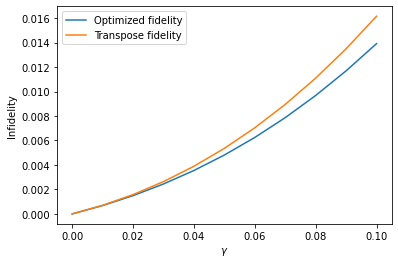

In [9]:
plt.plot(np.linspace(0,0.1,11),scs_sol_infid,label="Optimized fidelity")
plt.plot(np.linspace(0,0.1,11),trans_infid_list,label="Transpose fidelity")
plt.ylabel("Infidelity")
plt.xlabel(r"$\gamma$")
plt.legend()
plt.show()

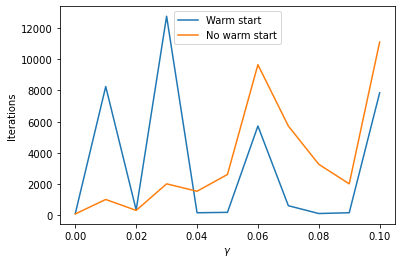

In [10]:
plt.plot(np.linspace(0,0.1,11),scs_sol_iter,label="Warm start")
plt.plot(np.linspace(0,0.1,11),scs_sol_iter_no_warm,label="No warm start")
plt.ylabel("Iterations")
plt.xlabel(r"$\gamma$")
plt.legend()
plt.show()

In [36]:
scs_sol_infid1 = []
scs_sol_iter1 = []
sol_diff = []
all_sols = []
prev_sol = None

for gamma in np.linspace(0,0.1,101):
    ####################
    # set parameters for GKP
    ####################
    print('--- gamma =',gamma)
    Delta = 0.481   # 1/2 Delta^2 \approx photon number
    l_cut = 20      # number of Kraus operator taken into consideration
    m_sum_cutoff=20 # accuracy order of basis overlap
    M_sum_cutoff=5  # accuracy order of QEC matrix
    
    ####################
    # calculate QEC matrix for GKP
    ####################
    M_GKP = QECmat_GKP(Delta = Delta, gamma = gamma, l_cut = l_cut, m_sum_cutoff = m_sum_cutoff, M_sum_cutoff = M_sum_cutoff).orth_M()
    
    ####################
    # calculate optimal/near optimal recovery
    ####################
    GKP_QECprocess.QECmat = M_GKP  #update GKP QEC matrix
    GKP_QECprocess.update_SCSprob()
    
    # calculate transpose fidelity result directly
    trans_infid = GKP_QECprocess.transpose_infid_M()
    print('transpose infid direct:',trans_infid)

    # calculate transpose choi matrix, and test consistency
    trans_choi = GKP_QECprocess.transpose_choi()
    prob0 = GKP_QECprocess.SDP_set_prob()  # setup SDP problem
    prob0.variables()[0].save_value(trans_choi)# feed choi into the variable
    print('transpose infid by choi:',1-prob0.objective.value)
    

    # do SDP optimization
    if prev_sol == None:
        y_guess = GKP_QECprocess.transchoi_y
    else:
        y_guess = prev_sol['y']
        
    sol = GKP_QECprocess.scs_solver.solve(warm_start = True,
                                          x = GKP_QECprocess.transchoi_x, 
                                          y = y_guess,
                                          s = GKP_QECprocess.transchoi_s)
    print('infid by SDP:',1+sol['info']['pobj'],'iter:',sol['info']['iter'])
    scs_sol_infid1.append(1+sol['info']['pobj'])
    scs_sol_iter1.append(sol['info']['iter'])
    if prev_sol == None:
        prev_sol = sol
        continue
    sol_diff.append([np.linalg.norm(sol['x']-prev_sol['x']), np.linalg.norm(sol['y']-prev_sol['y'])])
    prev_sol = sol
    all_sols.append(sol)

--- gamma = 0.0
transpose infid direct: 0.0
transpose infid by choi: 1.1102230246251565e-16
------------------------------------------------------------------
 iter | pri res | dua res |   gap   |   obj   |  scale  | time (s)
------------------------------------------------------------------
     0| 1.10e+01  2.80e-01  4.26e-11 -1.00e+00  2.35e-02  8.03e-03 
    50| 6.52e-07  5.20e-08  7.79e-07 -1.00e+00  2.35e-02  2.45e-01 
------------------------------------------------------------------
status:  solved
timings: total: 2.45e-01s = setup: 1.07e-04s + solve: 2.45e-01s
	 lin-sys: 4.46e-03s, cones: 2.34e-01s, accel: 2.71e-04s
------------------------------------------------------------------
objective = -0.999999
------------------------------------------------------------------
infid by SDP: 9.79395501476965e-07 iter: 50
--- gamma = 0.001
transpose infid direct: 6.291763909471726e-05
transpose infid by choi: 6.291763909460624e-05
--------------------------------------------------------

transpose infid direct: 0.0007032768163517389
transpose infid by choi: 0.0007032768163517389
------------------------------------------------------------------
 iter | pri res | dua res |   gap   |   obj   |  scale  | time (s)
------------------------------------------------------------------
     0| 2.32e-02  3.63e-04  2.45e-02 -9.87e-01  2.35e-02  1.71e-02 
   100| 5.52e-07  2.77e-07  8.63e-09 -9.99e-01  2.35e-02  4.87e-01 
------------------------------------------------------------------
status:  solved
timings: total: 4.87e-01s = setup: 8.78e-05s + solve: 4.87e-01s
	 lin-sys: 8.96e-03s, cones: 4.62e-01s, accel: 6.95e-04s
------------------------------------------------------------------
objective = -0.999318
------------------------------------------------------------------
infid by SDP: 0.0006820658236402766 iter: 100
--- gamma = 0.011
transpose infid direct: 0.0007828846096191722
transpose infid by choi: 0.0007828846096189501
-----------------------------------------------------

transpose infid direct: 0.0015788792758913983
transpose infid by choi: 0.0015788792758911763
------------------------------------------------------------------
 iter | pri res | dua res |   gap   |   obj   |  scale  | time (s)
------------------------------------------------------------------
     0| 2.27e-02  3.59e-04  2.31e-02 -9.87e-01  2.35e-02  1.64e-02 
   100| 6.91e-07  1.30e-06  5.66e-09 -9.99e-01  2.35e-02  4.91e-01 
------------------------------------------------------------------
status:  solved
timings: total: 4.91e-01s = setup: 6.95e-05s + solve: 4.91e-01s
	 lin-sys: 9.01e-03s, cones: 4.68e-01s, accel: 9.53e-04s
------------------------------------------------------------------
objective = -0.998507
------------------------------------------------------------------
infid by SDP: 0.0014932218437163636 iter: 100
--- gamma = 0.021
transpose infid direct: 0.0016763753848990648
transpose infid by choi: 0.0016763753848990648
-----------------------------------------------------

transpose infid direct: 0.002638626255126564
transpose infid by choi: 0.0026386262551262307
------------------------------------------------------------------
 iter | pri res | dua res |   gap   |   obj   |  scale  | time (s)
------------------------------------------------------------------
     0| 2.23e-02  5.00e-04  2.19e-02 -9.87e-01  2.35e-02  1.29e-02 
   150| 1.10e-06  9.71e-07  3.93e-08 -9.98e-01  2.35e-02  7.27e-01 
------------------------------------------------------------------
status:  solved
timings: total: 7.27e-01s = setup: 1.79e-04s + solve: 7.27e-01s
	 lin-sys: 1.37e-02s, cones: 7.00e-01s, accel: 1.23e-03s
------------------------------------------------------------------
objective = -0.997556
------------------------------------------------------------------
infid by SDP: 0.0024443864395528037 iter: 150
--- gamma = 0.031
transpose infid direct: 0.002755174308647357
transpose infid by choi: 0.002755174308647357
--------------------------------------------------------

transpose infid direct: 0.0038940260911700664
transpose infid by choi: 0.0038940260911701774
------------------------------------------------------------------
 iter | pri res | dua res |   gap   |   obj   |  scale  | time (s)
------------------------------------------------------------------
     0| 2.72e-02  6.70e-04  2.09e-02 -9.86e-01  2.35e-02  1.20e-02 
   125| 1.75e-06  9.19e-07  7.28e-09 -9.96e-01  2.35e-02  6.05e-01 
------------------------------------------------------------------
status:  solved
timings: total: 6.05e-01s = setup: 9.26e-05s + solve: 6.05e-01s
	 lin-sys: 1.21e-02s, cones: 5.80e-01s, accel: 7.77e-04s
------------------------------------------------------------------
objective = -0.996454
------------------------------------------------------------------
infid by SDP: 0.0035463488846385616 iter: 125
--- gamma = 0.041
transpose infid direct: 0.004030762267567156
transpose infid by choi: 0.004030762267567156
-------------------------------------------------------

transpose infid direct: 0.005356332498326899
transpose infid by choi: 0.00535633249832701
------------------------------------------------------------------
 iter | pri res | dua res |   gap   |   obj   |  scale  | time (s)
------------------------------------------------------------------
     0| 3.41e-02  8.39e-04  2.00e-02 -9.85e-01  2.35e-02  1.22e-02 
   125| 1.14e-06  4.06e-07  2.51e-08 -9.95e-01  2.35e-02  6.17e-01 
------------------------------------------------------------------
status:  solved
timings: total: 6.17e-01s = setup: 1.79e-04s + solve: 6.17e-01s
	 lin-sys: 1.15e-02s, cones: 5.93e-01s, accel: 7.86e-04s
------------------------------------------------------------------
objective = -0.995190
------------------------------------------------------------------
infid by SDP: 0.004810154497231212 iter: 125
--- gamma = 0.051000000000000004
transpose infid direct: 0.0055143694224584205
transpose infid by choi: 0.0055143694224583095
------------------------------------------

transpose infid direct: 0.0070365716520571775
transpose infid by choi: 0.0070365716520572885
------------------------------------------------------------------
 iter | pri res | dua res |   gap   |   obj   |  scale  | time (s)
------------------------------------------------------------------
     0| 4.09e-02  1.01e-03  1.93e-02 -9.84e-01  2.35e-02  1.41e-02 
   125| 7.66e-07  6.29e-07  1.83e-08 -9.94e-01  2.35e-02  6.45e-01 
------------------------------------------------------------------
status:  solved
timings: total: 6.46e-01s = setup: 1.85e-04s + solve: 6.45e-01s
	 lin-sys: 1.14e-02s, cones: 6.19e-01s, accel: 8.38e-04s
------------------------------------------------------------------
objective = -0.993754
------------------------------------------------------------------
infid by SDP: 0.0062460983902313805 iter: 125
--- gamma = 0.061
transpose infid direct: 0.007216999764469212
transpose infid by choi: 0.007216999764469212
-------------------------------------------------------

transpose infid direct: 0.008945546653718606
transpose infid by choi: 0.008945546653718495
------------------------------------------------------------------
 iter | pri res | dua res |   gap   |   obj   |  scale  | time (s)
------------------------------------------------------------------
     0| 4.77e-02  1.18e-03  1.87e-02 -9.83e-01  2.35e-02  1.37e-02 
   125| 4.39e-07  9.91e-07  1.49e-08 -9.92e-01  2.35e-02  6.43e-01 
------------------------------------------------------------------
status:  solved
timings: total: 6.43e-01s = setup: 9.04e-05s + solve: 6.43e-01s
	 lin-sys: 1.15e-02s, cones: 6.17e-01s, accel: 8.18e-04s
------------------------------------------------------------------
objective = -0.992136
------------------------------------------------------------------
infid by SDP: 0.007864333020243364 iter: 125
--- gamma = 0.07100000000000001
transpose infid direct: 0.009149433626245429
transpose infid by choi: 0.009149433626245429
--------------------------------------------

transpose infid direct: 0.011093824705170174
transpose infid by choi: 0.011093824705170396
------------------------------------------------------------------
 iter | pri res | dua res |   gap   |   obj   |  scale  | time (s)
------------------------------------------------------------------
     0| 5.45e-02  1.35e-03  1.82e-02 -9.81e-01  2.35e-02  1.18e-02 
   150| 6.78e-07  1.11e-06  3.30e-08 -9.90e-01  2.35e-02  7.70e-01 
------------------------------------------------------------------
status:  solved
timings: total: 7.70e-01s = setup: 9.03e-05s + solve: 7.70e-01s
	 lin-sys: 1.37e-02s, cones: 7.42e-01s, accel: 1.24e-03s
------------------------------------------------------------------
objective = -0.990325
------------------------------------------------------------------
infid by SDP: 0.009675050762405601 iter: 150
--- gamma = 0.081
transpose infid direct: 0.01132221338503614
transpose infid by choi: 0.011322213385036473
-----------------------------------------------------------

transpose infid direct: 0.013491711403480489
transpose infid by choi: 0.0134917114034806
------------------------------------------------------------------
 iter | pri res | dua res |   gap   |   obj   |  scale  | time (s)
------------------------------------------------------------------
     0| 6.12e-02  1.51e-03  1.79e-02 -9.80e-01  2.35e-02  1.60e-02 
   225| 4.60e-07  1.28e-06  9.73e-09 -9.88e-01  2.35e-02  1.17e+00 
------------------------------------------------------------------
status:  solved
timings: total: 1.17e+00s = setup: 9.39e-05s + solve: 1.17e+00s
	 lin-sys: 2.03e-02s, cones: 1.13e+00s, accel: 1.48e-03s
------------------------------------------------------------------
objective = -0.988313
------------------------------------------------------------------
infid by SDP: 0.011687450763526841 iter: 225
--- gamma = 0.091
transpose infid direct: 0.01374561667779517
transpose infid by choi: 0.013745616677795058
-------------------------------------------------------------

   250| 3.48e-07  1.63e-06  1.81e-08 -9.86e-01  2.35e-02  1.29e+00 
   325| 9.42e-07  2.62e-07  1.89e-08 -9.86e-01  2.35e-02  1.68e+00 
------------------------------------------------------------------
status:  solved
timings: total: 1.68e+00s = setup: 7.10e-05s + solve: 1.68e+00s
	 lin-sys: 2.91e-02s, cones: 1.63e+00s, accel: 2.50e-03s
------------------------------------------------------------------
objective = -0.986321
------------------------------------------------------------------
infid by SDP: 0.01367901572222241 iter: 325
--- gamma = 0.1
transpose infid direct: 0.0161492156999401
transpose infid by choi: 0.0161492156999401
------------------------------------------------------------------
 iter | pri res | dua res |   gap   |   obj   |  scale  | time (s)
------------------------------------------------------------------
     0| 6.78e-02  1.68e-03  1.76e-02 -9.78e-01  2.35e-02  1.31e-02 
   250| 3.44e-07  1.67e-06  1.93e-08 -9.86e-01  2.35e-02  1.29e+00 
   350| 8.34e-07  2.

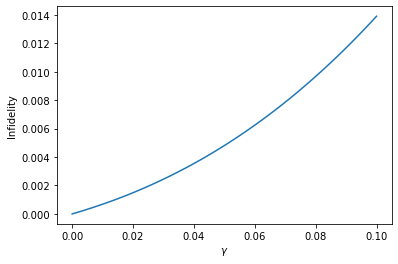

In [12]:
plt.plot(np.linspace(0,0.1,101),scs_sol_infid1)
plt.ylabel("Infidelity")
plt.xlabel(r"$\gamma$")
plt.show()

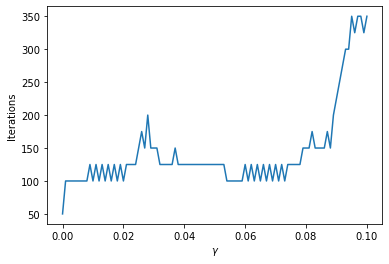

In [38]:
plt.plot(np.linspace(0,0.1,101),scs_sol_iter1)
plt.ylabel("Iterations")
plt.xlabel(r"$\gamma$")
plt.show()

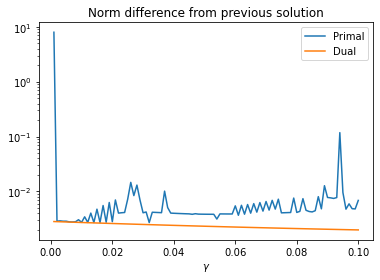

In [39]:
plt.title("Norm difference from previous solution")
plt.plot(np.linspace(0,0.1,101)[1:],np.array(sol_diff)[:,0],label="Primal")
plt.plot(np.linspace(0,0.1,101)[1:],np.array(sol_diff)[:,1],label="Dual")
plt.yscale('log')
plt.xlabel(r"$\gamma$")
plt.legend()
plt.show()

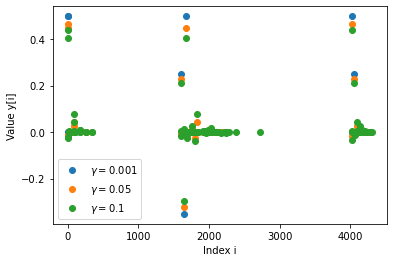

In [55]:
plt.scatter(range(len(all_sols[0]['y'])),np.where(np.abs(all_sols[1]['y'])<1e-4, np.nan, all_sols[1]['y']),label=r"$\gamma=0.001$")
plt.scatter(range(len(all_sols[0]['y'])),np.where(np.abs(all_sols[50]['y'])<1e-4, np.nan, all_sols[50]['y']),label=r"$\gamma=0.05$")
plt.scatter(range(len(all_sols[0]['y'])),np.where(np.abs(all_sols[-1]['y'])<1e-4, np.nan, all_sols[-1]['y']),label=r"$\gamma=0.1$")
plt.ylabel('Value y[i]')
plt.xlabel('Index i')
plt.legend()